# 1.- Descargar librerias

In [ ]:
%pip install numpy pandas tensorflow tensorflowjs matplotlib seaborn zipfile pillow scikit-learn gradio#instalar directamiente desde el cmd con permisos de administrador o ejecutar el IDE de uso como administrador

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 kB 1.7 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement zipfile (from versions: none)
ERROR: No matching distribution found for zipfile


# 2.-Importar librerias de librerias

In [ ]:
import numpy as np
import pandas as pd
import random
import os
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import sys
import time
import tensorflow.keras as keras
import tensorflow as tf
import re
import gradio as gr

from PIL import Image
from keras.layers import Input, Conv2D, Dense, Flatten, MaxPooling2D, Input, GlobalAveragePooling2D
from keras.layers import Normalization
from keras.models import Model, Sequential
from keras.utils import to_categorical, load_img
from keras.layers import Lambda
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [ ]:
%pip list

# 3.- Definir Contastantes

In [ ]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3


# Path where our data is located
base_path = "/content/drive/MyDrive/Proyecto-Taws-main/dataset-resized/"
categories = {0: 'paper', 1: 'cardboard', 2: 'plastic', 3: 'metal', 4: 'trash', 5: 'battery', 6: 'glass',7: 'biological'}



# 4.- Cargar datos a Data frame

In [ ]:
def add_class_name_prefix(df, col_name):
    df[col_name] = df[col_name].apply(lambda x: x[:re.search("\d",x).start()] + '/' + x)
    return df

# list conatining all the filenames in the dataset
filenames_list = []
# list to store the corresponding category, note that each folder of the dataset has one class of data
categories_list = []

for category in categories:
    filenames = os.listdir(base_path + categories[category])

    filenames_list = filenames_list  +filenames
    categories_list = categories_list + [category] * len(filenames)

df = pd.DataFrame({
    'filename': filenames_list,
    'category': categories_list
})

df = add_class_name_prefix(df, 'filename')
print(df)
# Shuffle the dataframe
df = df.sample(frac=1).reset_index(drop=True)

print('number of elements = ' , len(df))

                          filename  category
0               paper/paper277.jpg         0
1               paper/paper903.jpg         0
2               paper/paper922.jpg         0
3               paper/paper125.jpg         0
4               paper/paper670.jpg         0
...                            ...       ...
7619  biological/biological901.jpg         7
7620   biological/biological31.jpg         7
7621  biological/biological820.jpg         7
7622  biological/biological630.jpg         7
7623  biological/biological811.jpg         7

[7624 rows x 2 columns]
number of elements =  7624


In [ ]:
df

,filename,category
0,glass/glass496.jpg,6
1,glass/glass426210210_1.jpg,6
2,paper/paper449.jpg,0
3,metal/metal520.jpg,3
4,biological/biological980.jpg,7
...,...,...
7619,cardboard/cardboard170.jpg,1
7620,cardboard/cardboard733.jpg,1
7621,glass/glass340.jpg,6
7622,paper/paper888.jpg,0


# 4.1.- Visualizar imagenes de manera aleatoria

plastic/plastic557.jpg


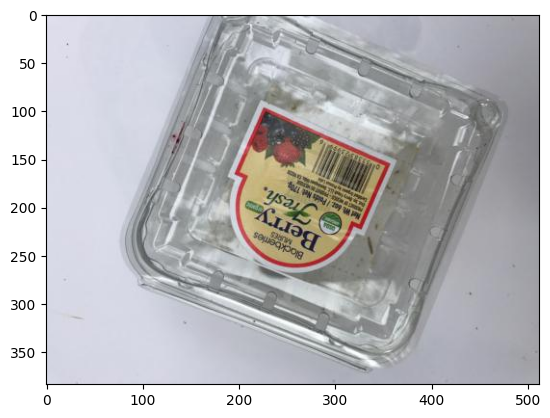

In [ ]:
random_row = random.randint(0, len(df)-1)
sample = df.iloc[random_row]
randomimage = load_img(base_path +sample['filename'])
print(sample['filename'])
plt.imshow(randomimage)

# 4.2.- Visualizar cantidad de datos que contiene cada clase

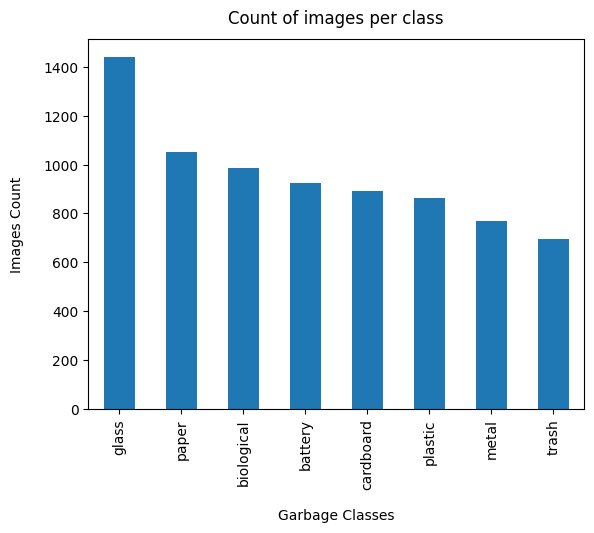

In [ ]:
df_visualization = df.copy()
# Change the catgegories from numbers to names
df_visualization['category'] = df_visualization['category'].apply(lambda x:categories[x] )

df_visualization['category'].value_counts().plot.bar(x = 'count', y = 'category' )

plt.xlabel("Garbage Classes", labelpad=14)
plt.ylabel("Images Count", labelpad=14)
plt.title("Count of images per class", y=1.02);

# 5.- Seperar datos del Dataset

In [ ]:

df["category"] = df["category"].replace(categories)


train_df, validate_df = train_test_split(df, test_size=0.2, random_state=42)
validate_df, test_df = train_test_split(validate_df, test_size=0.5, random_state=42)

train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

print('train size = ', total_validate , 'validate size = ', total_validate, 'test size = ', test_df.shape[0])

train size =  762 validate size =  762 test size =  763


# 6.- Deep learning(Uso del modelo pre entrenado mobilenetv2) fecha(4/9/2023)
### Si se descargar los pesos de el modelo en https://storage.googleapis.com/tensorflow/keras-applications/mobilenet_v2/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5
Mostrar en carpeta


In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
import keras.applications.mobilenet_v2 as mobilenetv2

mobilenetv2_layer = mobilenetv2.MobileNetV2(include_top = False, input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT,IMAGE_CHANNELS),
                    weights = '/content/drive/MyDrive/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5')

# We don't want to train the imported weights
mobilenetv2_layer.trainable = False


model = Sequential()
model.add(keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))

#create a custom layer to apply the preprocessing
def mobilenetv2_preprocessing(img):
    return mobilenetv2.preprocess_input(img)

model.add(Lambda(mobilenetv2_preprocessing))

model.add(mobilenetv2_layer)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(Dense(len(categories), activation='softmax'))

#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

#model.summary()

# 7.- Entrenamiento

# 7.1.- Aumento de datos(tecnica de entrenmiento)

In [ ]:
batch_size=64

train_datagen = image.ImageDataGenerator(
    #rotation_range=30,
    #shear_range=0.1,
    #zoom_range=0.3,
    #horizontal_flip=True,
    #vertical_flip = True,
    #width_shift_range=0.2,
    #height_shift_range=0.2
    ##  Augmentation End  ###
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    base_path,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 6114 validated image filenames belonging to 8 classes.


In [ ]:
validation_datagen = image.ImageDataGenerator()

validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    base_path,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 764 validated image filenames belonging to 8 classes.


In [ ]:
test_datagen = image.ImageDataGenerator()
test_generator = test_datagen.flow_from_dataframe(
    test_df,
    base_path,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False  # No necesitamos mezclar el conjunto de prueba para evaluarlo
)

Found 765 validated image filenames belonging to 8 classes.


# 7.2 Early stopping (tecnica de entrenamiento de datos)

In [ ]:
early_stop = EarlyStopping(patience = 2, verbose = 1, monitor='val_categorical_accuracy' , mode='max', min_delta=0.001, restore_best_weights = True)

callbacks = [early_stop]

In [ ]:
EPOCHS = 50
history = model.fit_generator(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

C:\Users\hombr\AppData\Local\Temp\ipykernel_360\2090552294.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/50
95/95 [==============================] - 71s 726ms/step - loss: 0.8000 - categorical_accuracy: 0.7260 - val_loss: 0.3659 - val_categorical_accuracy: 0.8935
Epoch 2/50
95/95 [==============================] - 67s 709ms/step - loss: 0.3455 - categorical_accuracy: 0.8950 - val_loss: 0.2840 - val_categorical_accuracy: 0.9062
Epoch 3/50
95/95 [==============================] - 67s 706ms/step - loss: 0.2666 - categorical_accuracy: 0.9193 - val_loss: 0.2356 - val_categorical_accuracy: 0.9261
Epoch 4/50
95/95 [==============================] - 67s 706ms/step - loss: 0.2202 - categorical_accuracy: 0.9337 - val_loss: 0.2428 - val_categorical_accuracy: 0.9219
Epoch 5/50
95/95 [==============================] - 67s 709ms/step - loss: 0.1899 - categorical_accuracy: 0.9466 - val_loss: 0.2295 - val_categorical_accuracy: 0.9247
Epoch 5: early stopping


# 8.- Rendimiento

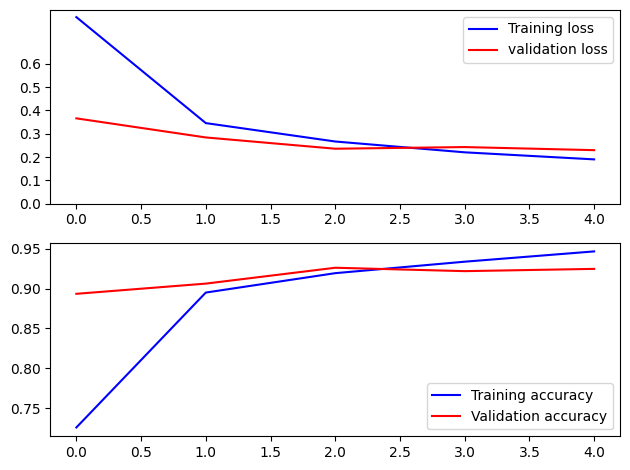

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_yticks(np.arange(0, 0.7, 0.1))
ax1.legend()

ax2.plot(history.history['categorical_accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_categorical_accuracy'], color='r',label="Validation accuracy")
ax2.legend()

legend = plt.legend(loc='best')
plt.tight_layout()
plt.show()

# 9.-Testeo

12/12 [==============================] - 11s 885ms/step


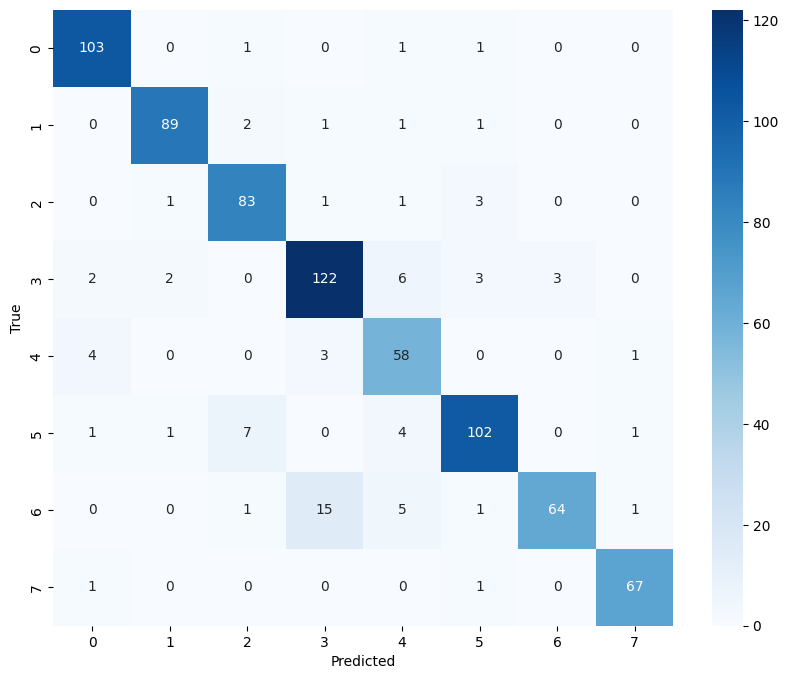

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes  # Obtener las etiquetas verdaderas del generador de prueba

# Calcular la matriz de confusión
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# Visualizar la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_true, y_pred_classes)
print(f'Accuracy: {accuracy}')

Accuracy: 0.8993464052287582


In [ ]:
loss = model.evaluate(test_generator, verbose=0)[0]
print(f'Loss: {loss}')

Loss: 0.30264586210250854


In [ ]:
from sklearn.metrics import f1_score
f1 = f1_score(y_true, y_pred_classes, average='weighted')
print(f'F1 Score: {f1}')

F1 Score: 0.8988584154234425


# 10.- Guardar Modelo

In [ ]:
model.save("modelo.h5")

# 11.- Exportar el modelo en js

In [ ]:
!mkdir carpeta_salida

Ya existe el subdirectorio o el archivo carpeta_salida.


In [ ]:
!tensorflowjs_converter --input_format keras modelo.h5 carpeta_salida

# 12.- Diseño Interfaz

In [ ]:
model.load_weights('/content/drive/MyDrive/Proyecto-Taws-main/modelo.h5')

In [49]:
def clasificar(img):
  img_reshape = img.reshape(-1,224,224,3)
  pred = model.predict(img_reshape)[0]
  return {categories[i]:float(pred[i]) for i in range(7)}


interfaz = gr.Interface(fn=clasificar, inputs=gr.inputs.Image(shape=(224,224),source='upload',label='Captura desde cámara'),
                        outputs=gr.outputs.Label(num_top_classes=7),capture_session=True).launch(debug = False,share='True')


<ipython-input-49-af4a211506f7>:9: GradioDeprecationWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  interfaz = gr.Interface(fn=clasificar, inputs=gr.inputs.Image(shape=(224,224),source='upload',label='Captura desde cámara'),
<ipython-input-49-af4a211506f7>:9: GradioDeprecationWarning: `optional` parameter is deprecated, and it has no effect
  interfaz = gr.Interface(fn=clasificar, inputs=gr.inputs.Image(shape=(224,224),source='upload',label='Captura desde cámara'),
<ipython-input-49-af4a211506f7>:10: GradioDeprecationWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  outputs=gr.outputs.Label(num_top_classes=7),capture_session=True).launch(debug = False,share='True')
<ipython-input-49-af4a211506f7>:10: GradioUnusedKwargWarning: You have unused kwarg parameters in Label, please remove them: {'type': 'aut

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://f2d0a993bf58595420.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
